In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
import math
from math import log10
import time

from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torchvision.models.vgg import vgg19
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

import cv2
from tqdm import tqdm
#import pytorch_ssim

In [10]:
import os
from PIL import Image

# 데이터셋 디렉토리 경로 설정
dataset_path = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/JPEGImages'

# 가로 또는 세로 크기가 96 이하인 이미지를 저장할 리스트
small_images = []

# 데이터셋 경로의 모든 파일을 탐색
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png','.jpg' ,'.jpeg' ,'.PNG' ,'.JPG' ,'.JPEG')):  # 이미지 확장자 필터
            image_path = os.path.join(root, file)
            try:
                # 이미지 열기
                with Image.open(image_path) as img:
                    width, height = img.size
                    # 가로 또는 세로가 96 이하인지 확인
                    if width <= 96 or height <= 96:
                        small_images.append(image_path)
                        print(f"Found small image: {file}, Size: {width}x{height}")
                        # 이미지 삭제
                        os.remove(image_path)
                        print(f"Deleted image: {file}")
                        
            except Exception as e:
                print(f"Error opening image {file}: {e}")

# 최종 결과 출력
print(f"Total small images found: {len(small_images)}")


Total small images found: 0


In [ ]:
import os
import shutil

# 데이터셋 디렉토리 및 이동할 디렉토리 설정
dataset_path = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/JPEGImages'
val_images_path = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/Val_Images'

# Val_Images 폴더가 없으면 생성
if not os.path.exists(val_images_path):
    os.makedirs(val_images_path)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# 파일 이름 기준 정렬 (원하는 다른 기준으로 정렬할 수도 있음)
image_files.sort()

# 마지막 300장 선택
images_to_move = image_files[-300:]

# 이미지 이동
for image in images_to_move:
    source = os.path.join(dataset_path, image)
    destination = os.path.join(val_images_path, image)
    
    try:
        # 이미지 이동
        shutil.move(source, destination)
        print(f"Moved {image} to {val_images_path}")
    except Exception as e:
        print(f"Error moving {image}: {e}")

# 최종 결과 출력
print(f"Total images moved: {len(images_to_move)}")


In [2]:
crop_size = 96
if(crop_size % 4) != 0:
    crop_size = crop_size - (crop_size%4)

upscale_factor = 4
epoch = 250
batch_size = 64
dataset_dir = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/JPEGImages'
val_dataset_dir = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/Val_Images'
save_path = 'C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/save_model'

print("train_dataset: {}개, val_dataset: {}개".format(len(listdir(dataset_dir)), len(listdir(val_dataset_dir))))

train_dataset: 16823개, val_dataset: 300개


## Custom Dataset에 필요한 함수 선언

In [3]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png','.jpg' ,'.jpeg' ,'.PNG' ,'.JPG' ,'.JPEG'])

def hr_transform(crop_size):
    return Compose([RandomCrop(crop_size), ToTensor()])

def lr_transform(crop_size, upscale_factor):
    return Compose([ToPILImage(), Resize(crop_size//upscale_factor, interpolation=Image.BICUBIC), ToTensor()])

## Custom Dataset 선언

In [4]:
class TrainDataset(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDataset, self).__init__()

        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.hr_transform = hr_transform(crop_size)
        self.lr_transform = lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image
    
    def __len__(self):
        return len(self.image_filenames)
    
#     # 처음 몇 개의 파일을 출력하는 함수 추가
#     def print_image_filenames(self, num_files=10):
#         print(f"Displaying first {num_files} files out of {len(self.image_filenames)}:")
#         for i, filename in enumerate(self.image_filenames[:num_files]):
#             print(f"{i+1}. {filename}")

# # TrainDataset 클래스 사용 예시
# dataset = TrainDataset('C:/Users/kimin/st_defense_lab/st-defense-lab/SRGAN/VOC2012_train_val/JPEGImages', 256, 2)
# dataset.print_image_filenames(10)  # 처음 10개의 파일을 출력

class ValDataset(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(ValDataset, self).__init__()

        self.image_filenames = [join(dataset_dir, x) for x in list(dataset_dir) if is_image_file(x)]
        self.upscale_factor = upscale_factor

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])
        hr_image = CenterCrop(crop_size)(hr_image)

        lr_image = Resize(crop_size // self.upscale_factor, interpolation = Image.BICUBIC)(hr_image)
        bicubic_hr_image = Resize(crop_size, interpolation = Image.BICUBIC)(lr_image)

        return ToTensor()(lr_image), ToTensor()(bicubic_hr_image), ToTensor(hr_image)
    
    def __len__(self):
        return len(self.image_filenames)
    

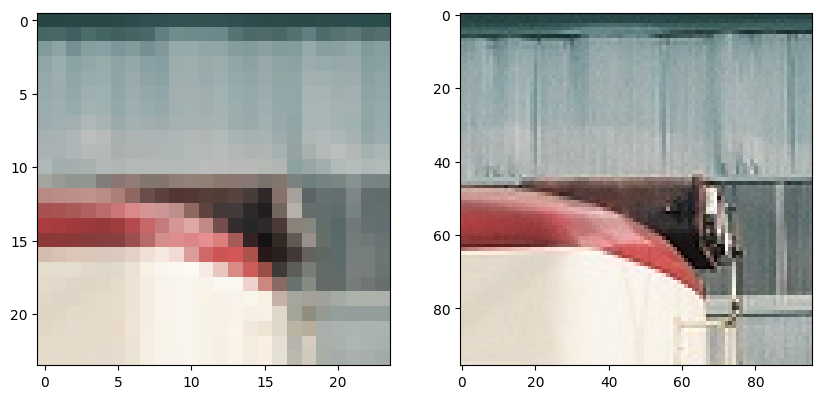

In [5]:
train_dataset = TrainDataset(dataset_dir, crop_size, upscale_factor)
val_dataset = ValDataset(val_dataset_dir, crop_size, upscale_factor)

hr, lr = train_dataset[4]

fig,axes = plt.subplots(1,2,figsize = (10,10))

axes[0].imshow(hr.permute(1,2,0))
axes[1].imshow(lr.permute(1,2,0))

In [6]:
train_dataloader = DataLoader(train_dataset, num_workers = 2,  batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset,num_workers =2, batch_size = 1, shuffle = False)

## SRGAN Architecture
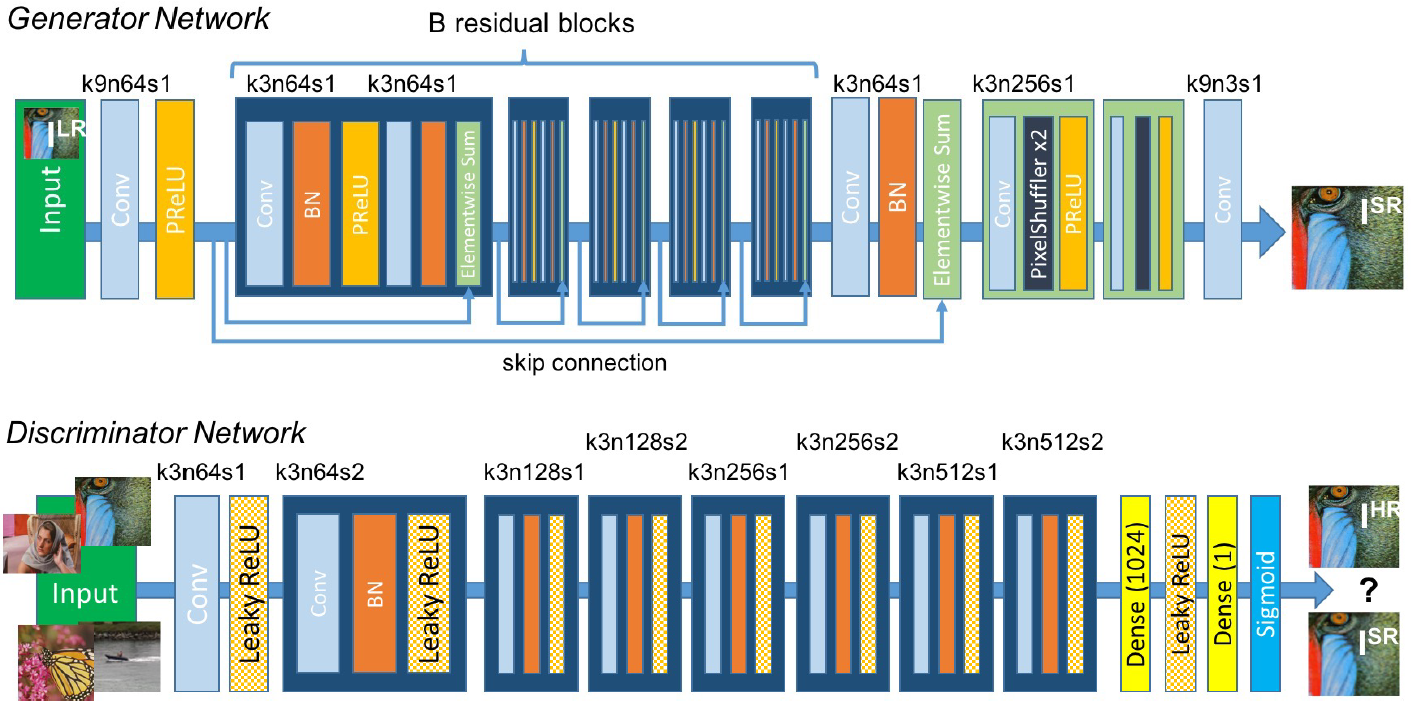
### Code 구현 과정
> 1. Loss Function
> 2. Definition Model (Generator)
> 3. Definition Model (Discriminator)

#### 1. Loss Function 구현
        TV_Loss를 적용한 Loss Function

In [7]:
# =================================
#
#          TV_Loss 적용
#
# =================================
class Generator_Loss(nn.Module):
    def __init__(self):
        super(Generator_Loss, self).__init__()
        vgg = vgg19(pretrained=True)
        loss_net = nn.Sequential(*list(vgg.features[:36])).eval()       # VGG19 network에서 첫번 째 30개의 layer(4번째 maxpooling layer 이전의 Convolution layer)들을 
                                                                        # 하나의 Sequential 모듈로 묶어 Forward pass만 진행
                                                                        # 여기서 .eval()을 통해 학습 하지 않고 pre-trained된 weight로 feature map 추출

        for params in loss_net.parameters():               # VGG 네트워크는 학습되지 않도록 고정
            params.requires_grad = False
        
        self.loss_net = loss_net
        self.mse = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, netD_out, fake_img, real_img):
        content_loss = self.mse(self.loss_net(fake_img), self.loss_net(real_img))   #Content Loss: Feature Map 간 MSE Loss 계산
        adversarial_loss = torch.mean(1 - netD_out)                                 # Adversarial Loss: Generator Loss, 학습을 위해 Log를 사용하지 않음
        perceptual_loss = content_loss*0.006 + adversarial_loss*0.001               # Perceptual Loss: Cotent loss와 Adversarial의 가중치 합
        tv_loss = self.tv_loss(fake_img)                                            # Total Loss: TV Loss 추가, 이미지가 사실적이게 보이는 효과

        return perceptual_loss + tv_loss*2e-8

class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

        논문의 수식대로 구현한 Loss Function (TV_Loss X)

In [12]:
# =================================
#
#          TV_Loss 적용 X
#
# =================================
class Generator_Loss(nn.Module):
    def __init__(self):
        
        super(Generator_Loss, self).__init__()
        vgg = vgg19(pretrained=True)
        loss_net = nn.Sequential(*list(vgg.features[:36])).eval()       # VGG19 network에서 첫번 째 30개의 layer(4번째 maxpooling layer 이전의 Convolution layer)들을 
                                                                        # 하나의 Sequential 모듈로 묶어 Forward pass만 진행
                                                                        # 여기서 .eval()을 통해 학습 하지 않고 pre-trained된 weight로 feature map 추출

        for params in loss_net.parameters():               # VGG 네트워크는 학습되지 않도록 고정
            params.requires_grad = False
        
        self.loss_net = loss_net
        self.mse = nn.MSELoss()

    def forward(self, netD_out, fake_img, real_img):
        content_loss = self.mse(self.loss_net(fake_img), self.loss_net(real_img))
        adversarial_loss = torch.mean(1 - netD_out)
        # adversarial_loss = -torch.mean(torch.log(netD_out))
        perceptual_loss = content_loss*0.006 + adversarial_loss*0.001

        return perceptual_loss

IndentationError: expected an indented block (3408330284.py, line 7)

#### 2. Definition Model - Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))             # UpsampleBLock의 개수를 정하기 위한 변수
                                                                        # scale_factor = 4를 log2(4)=2로 하여  UpsampleBLock 개수를 2개로 설정
                                                                        # 한꺼번에 4배로 upscaling하는 방법이 아닌 2배 upscaling을 두번 하는 것으로 함
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]          # upsample_block_num은 업스케일링이 몇 단계로 이루어 지는지 결정
                                                                                    # scale_factor = 4라면 upsample_block_num = 2가 되어 두 개의 Upsample Block이 필요
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)
    
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)           # skip connection

        return (torch.tanh(block8) + 1) / 2             # SRGAN의 출력이 0~1 or 0~255 범위여야하지만 -1~1사이로 나올 수 있어, 0~1 범위로 변환 필요
                                                        # tanh -> -1~1 범위 -> +1을 하여 0~2 범위 -> /2를 하여 0~1 범위로 출력하도록 함

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        
        return x + residual
    
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels*up_scale**2, kernel_size=3, padding=1)       # 이미지 해상도를 높이는 역할
                                                                                                    # UpsampleBLock에서는 2배 upscaling하는것이 default
                                                                                                    #                           => up_scale = 2
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)

        return x

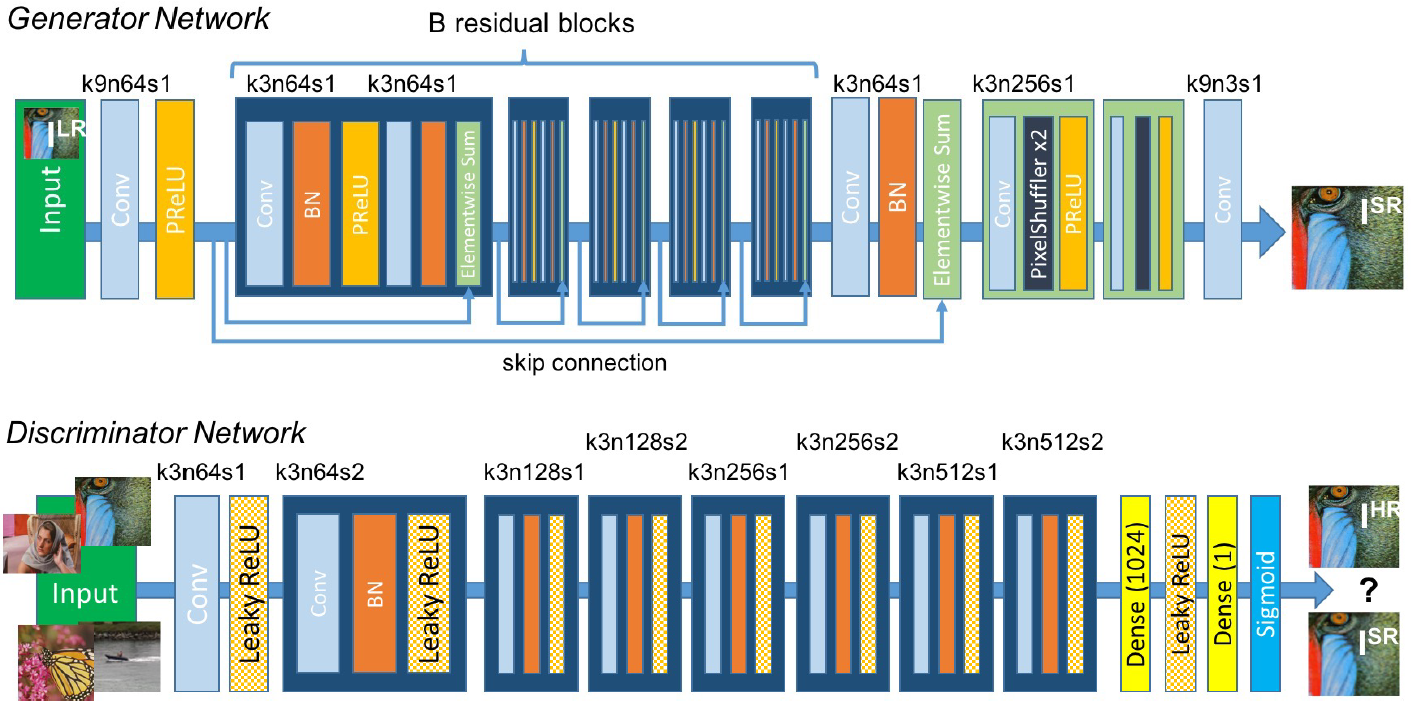

#### 3. Definition Model - Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)

        )
    
    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

netG = Generator(4)
netD = Discriminator()

Generator_loss = Generator_Loss()

netG.to(device)
netD.to(device)
Generator_loss.to(device)

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

# GPU 사용 여부 확인
if device.type == 'cuda':
    print(f'GPU 사용 중: {torch.cuda.get_device_name(0)}')
else:
    print('CPU 사용 중')

# 추가로 모델이 GPU에 있는지 확인
print(f'netG가 GPU에 있는지 확인: {next(netG.parameters()).is_cuda}')
print(f'netD가 GPU에 있는지 확인: {next(netD.parameters()).is_cuda}')
print(f'Generator_loss가 GPU에 있는지 확인: {next(Generator_loss.parameters()).is_cuda}')

c:\Users\kimin\anaconda3\envs\defense_lab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kimin\anaconda3\envs\defense_lab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GPU 사용 중: NVIDIA GeForce RTX 4070
netG가 GPU에 있는지 확인: True
netD가 GPU에 있는지 확인: True
Generator_loss가 GPU에 있는지 확인: True


In [ ]:
for epoch in range(1,epoch+1):
    print("Start {} epochs ... ".format(epoch+1))
    train_bar = tqdm(train_dataloader)

    netG.train()
    netD.train()

    for lr_img, hr_img in train_bar:
        
        lr_img = lr_img.to(device)
        hr_img = hr_img.to(device)

        # ===================================
        #  Train Discriminator : Maximize D(x) - 1 - D(G(z))
        # ===================================

        fake_img = netG(lr_img)

        netD.zero_grad()
        loss = netD(hr_img).mean() - 1 + netD(fake_img).mean() # netD의 결과값은 배치크기 만큼의 확률값 벡터
        loss.backward(retain_graph = True)
        optimizerD.step()

        # ===================================
        #  Train Generator : Mimize 1 - D(G(z)) + Content Loss + TV Loss
        # ===================================

        netG.zero_grad()
        ## 아래 두 줄은 구글 코랩 런타임 에러 방지를 위해 추가
        fake_img = netG(lr_img)
        netD_output = netD(fake_img).mean()
        ##
        loss = Generator_loss(netD_output, fake_img, hr_img)
        loss.backward()

        fake_img = netG(lr_img)
        netD_output = netD(fake_img).mean()

        optimizerG.step()

    # ===================================
    #  Epoch 당 ValDataset 검증
    # ===================================
    netG.eval()

    with torch.no_grad():
        val_bar = tqdm(val_dataloader)
        valing_results = {'mse': 0, 'psnr': 0, 'batch_sizes': 0}

        for val_lr_img, val_bicubic_img, val_hr_img in val_bar:
            batch_size = val_lr_img.size(0)
            valing_results['batch_sizes'] += batch_size

            val_lr_img= val_lr_img.to(device)
            val_hr_img = val_hr_img.to(device)
            val_bicubic_img = val_bicubic_img.to(device)

            val_sr_img = netG(val_lr_img)

            batch_mse = ((val_sr_img - val_hr_img)**2).data.mean()
            valing_results['mse'] += (batch_mse * batch_size) # 누적 mse

            valing_results['psnr'] = 10 * log10((val_hr_img.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))

            print("Val_Score >> PSNR: {}".format(valing_results['psnr']))

torch.save(netG.state_dict(), save_path + '/' + str(epoch) + 'epochs')
torch.save(netD.state_dict(), save_path + '/' + str(epoch) + 'epochs')

Start 2 epochs ... 


  0%|          | 0/263 [00:00<?, ?it/s]